# Serializing pulse programs

Naoki Kanazawa (knzwnao@jp.ibm.com)

**Relevant PRs**
- Move QPY serializer to own module [#7582](https://github.com/Qiskit/qiskit-terra/pull/7582)
- Serializable parametric pulse [#7821](https://github.com/Qiskit/qiskit-terra/pull/7821)
- QPY schedule serialization [#7300](https://github.com/Qiskit/qiskit-terra/pull/7300)

Eventually it became a huge PR. Thanks @wshanks, @eggerdj, @mtreinish, @jakelishman for careful review!

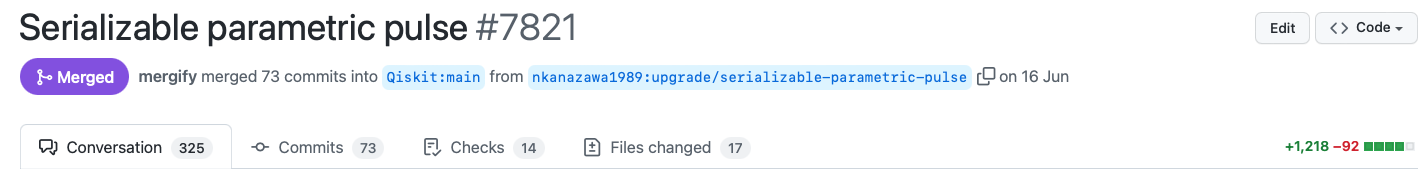

# Background

In Qiskit Experiments (QE) calibrations, we would expect following workflow.

1. Define a custom gate instruction with `ScheduleBlock`.
2. Set the gate schedule to `Calibrations` instance.
3. Run a sequence of calibration experiments and update the parameter table.
4. Share the complete `Calibrations` instance with collaborators.

To realize the step4, we should be able to serialize pulse programs. However, a serialize format for `ScheduleBlock` was missing in Qiskit, except for the PulseQobj which doesn't guarantee backward compatibility.

In this work, pulse schedule support is added to the QPY module.

In [1]:
import sys
from io import BytesIO
from qiskit import pulse, circuit, qpy

### Demo 1

Serializing a parameterized schedule.

In [2]:
my_pulse = pulse.Gaussian(
    circuit.Parameter("duration"),
    circuit.Parameter("amp"), 
    circuit.Parameter("sigma"),
)

with pulse.build(name="my_gate") as my_gate:
    pulse.shift_phase(1.57, pulse.DriveChannel(0))
    pulse.play(my_pulse, pulse.DriveChannel(0))

file_like = BytesIO()

qpy.dump(my_gate, file_like)
file_like.seek(0)
load_gate = qpy.load(file_like)[0]

assert my_gate == load_gate

print(sys.getsizeof(file_like.getvalue()))

579


### Demo 2

Serializing a circuit with a calibration.

In [3]:
my_gate_op = circuit.Gate("my_gate", 1, my_gate.parameters)

my_circ = circuit.QuantumCircuit(1)
my_circ.append(my_gate_op, [0])
my_circ.measure_active()
my_circ.add_calibration(my_gate_op, (0,), my_gate)

file_like = BytesIO()

qpy.dump(my_circ, file_like)
file_like.seek(0)
load_circ = qpy.load(file_like)[0]

assert my_circ == load_circ

print(sys.getsizeof(file_like.getvalue()))

1085


### Deep dive

This is how `ScheduleBlock` is prepared inside the builder context. Objects are simple native python values and Qiskit classes except for pulse.

In [4]:
from qiskit.pulse.schedule import ScheduleBlock
from qiskit.pulse.transforms import AlignLeft
from qiskit.pulse.instructions import ShiftPhase, Play
from qiskit.pulse.channels import DriveChannel

context = AlignLeft()
channel = DriveChannel(0)

inst1 = ShiftPhase(1.57, channel)
inst2 = Play(my_pulse, channel)

sched_obj = ScheduleBlock(alignment_context=context)
sched_obj.append(inst1)
sched_obj.append(inst2)

ScheduleBlock(ShiftPhase(1.57, DriveChannel(0)), Play(Gaussian(duration=duration, amp=amp, sigma=sigma), DriveChannel(0)), name="block1", transform=AlignLeft())

# Qiskit Pulse waveform models

### Waveform

We first introduced `functional_pulse` decorator which transforms function into `Waveform`. Basically this is a wrapper of numpy array.

In [5]:
import numpy as np

from qiskit.pulse.library.samplers.decorators import functional_pulse

@functional_pulse
def my_pulse(duration, amp, sigma):
    center = duration / 2
    return amp * np.exp(-((np.arange(duration)-center) / sigma) ** 2 / 2)

my_pulse(16, 0.1, 4)

Waveform(array([0.01353353+0.j, 0.02162652+0.j, 0.03246525+0.j, 0.04578334+0.j,
       0.06065307+0.j, 0.07548396+0.j, 0.08824969+0.j, 0.09692332+0.j,
       0.1       +0.j, 0.09692332+0.j, 0.08824969+0.j, 0.07548396+0.j,
       0.06065307+0.j, 0.04578334+0.j, 0.03246525+0.j, 0.02162652+0.j]))

### ParametricPulse

Later we added a parametric form to reduce Qobj size. This allowed us to directly instantiate pulse with `Parameter` objects.

In [6]:
from qiskit.pulse.library.parametric_pulses import Gaussian as ParametricGaussian

my_pulse_parametric = ParametricGaussian(16, 0.1, 4)
my_pulse_parametric

Gaussian(duration=16, amp=(0.1+0j), sigma=4)

In [7]:
my_pulse_parametric_unassigned = ParametricGaussian(circuit.Parameter("duration"), 0.1, 4)
my_pulse_parametric_unassigned

Gaussian(duration=duration, amp=(0.1+0j), sigma=4)

However, this parametric form has several issues.

- Pulse envelope is not encapslated. This means definition exists separately on the host and client.
- Experimentalist cannot use new pulse without upgrading Qiskit Terra.

The `.get_waveform()` method generates samples to load into waveform memory. This internally calls the `gaussian` function. QPY cannot serialize such callable.

In [8]:
from qiskit.pulse.library.discrete import gaussian

gaussian(16, 0.1, 4) == my_pulse_parametric.get_waveform()

True

### SymbolicPulse

With qiskit-terra/#7821 we have introduced new parametric form so called `SymbolicPulse`. This encapslates the sample generator and parameter validation formula as symbolic equations.

In [9]:
from qiskit.pulse.library.symbolic_pulses import Gaussian as SymbolicGaussian

my_pulse_symbolic = SymbolicGaussian(16, 0.1, 4)
my_pulse_symbolic

Gaussian(duration=16, amp=(0.1+0j), sigma=4)

In [10]:
my_pulse_parametric.get_waveform() == my_pulse_symbolic.get_waveform()

True

Envelope is now represented by a SymPy or symengine symbolic equation. This object can be serialized through the packages. 

In [11]:
my_pulse_symbolic.envelope

amp*(-exp((-1/2)*(1 + (1/2)*duration)**2/sigma**2) + exp((-1/2)*((-1/2)*duration + t)**2/sigma**2))/(1 - exp((-1/2)*(1 + (1/2)*duration)**2/sigma**2))

This symbolic equation is lambdified when it is called for the first time and then cached for performance.

In [12]:
my_pulse_symbolic._envelope_lam

<function qiskit.pulse.library.symbolic_pulses.LambdifiedExpression.__set__.<locals>._wrapped_lamb(*args)>

This also means an experimentalist can define any pulse without defining a subclass. This code defines a parametric tangential envelope which doesn't exist in Terra today.

In [13]:
from qiskit.pulse.library.symbolic_pulses import SymbolicPulse
from sympy import symbols, tanh

t, duration, sigma, amp = symbols("t duration sigma amp")
expr = amp * (tanh(t/sigma) + tanh((duration-t)/sigma) - 1)
constraints = duration > sigma

expr, constraints

(amp*(tanh(t/sigma) + tanh((duration - t)/sigma) - 1), duration > sigma)

We can directly instantiate symbolic pulse with expressions.

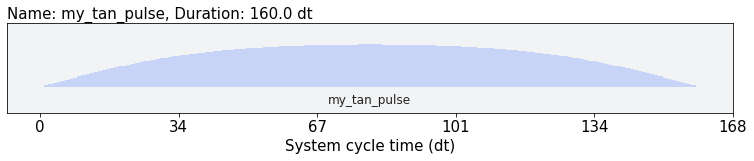

In [14]:
my_tan_pulse = SymbolicPulse(
    pulse_type="Tangential", 
    duration=160, 
    parameters={"amp": 0.1, "sigma": 40},
    envelope=expr,
    constraints=constraints,
    valid_amp_conditions=amp < 1,
    name="my_tan_pulse",
)
my_tan_pulse.draw()

### Performance check

Symbolic pulses have an overhad of initializing symbolic equation per instance, but performance of generating samples is not quite bad thanks to cached lambda functions. 

In [15]:
%%timeit
SymbolicGaussian(160, 0.1, 40).get_waveform()

283 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
ParametricGaussian(160, 0.1, 40).get_waveform()

68.2 µs ± 9.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Basically the overhead comes from array broadcasting. This must be solved by sympy/symengine, or can we implement some fast symbolic equation platform written in rust/julia?

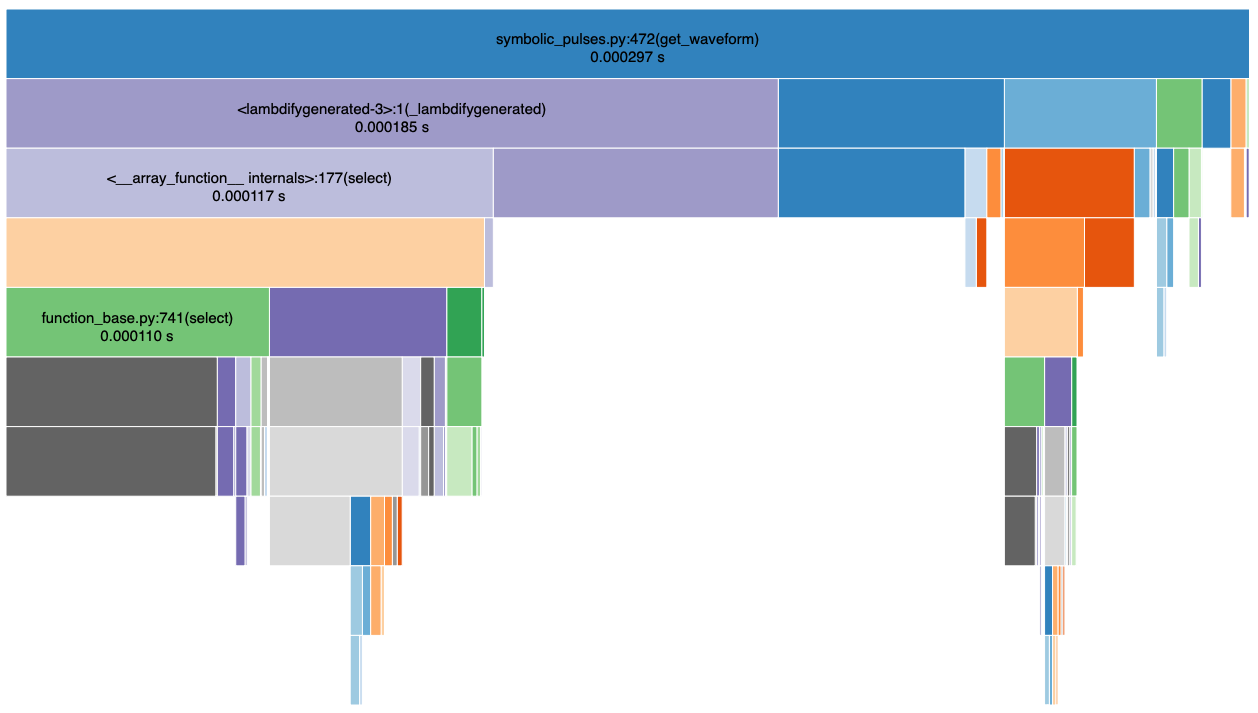

# Future updates

- QPY support for `Schedule`
- Native symengine expression serialization -- x10 speedup (qiskit-terra/#8232, on hold)
- Remove subclasses (Ganssuain, GaussianSquare, Drag, Constant) (qiskit-terra/#8278)
- Further performance optimization